In [39]:
import numpy as np
import os
import pathlib
import folium
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pathlib import Path
import warnings
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

In [40]:
%reload_ext autoreload

In this notebook, air temperature from ARPA (_Agenzia Regionale per la Protezione dell'Ambiente_) and CML (_Centro Meteorologico Lomardo_) sensor networks are used. 
Data availability:
- **ARPA** - it can be downloaded directly from the ARPA Lombardia website, [HERE](https://www.arpalombardia.it/temi-ambientali/meteo-e-clima/form-richiesta-dati/). For other Italian regions, different ways to retrieve datasets are available.
- **CML** - not available publicly, for any inquiries, contact CML directly, [HERE](http://www.centrometeolombardo.com/content.asp?CatId=465&ContentType=CML).

_Note: Only ARPA is provided, raw CML data is not available here, but the outputs of this analysis are in Notebook 4, where air temperature prediction is executed._

In [41]:
ARPA_source = './Data/CML-ARPA/ARPA/'
CML_source = './Data/CML-ARPA/CML/'

# **ARPA Pre-processing**

ARPA observations are high-quality, however, preliminary data preparation and cleaning were performed. Missing values (-999) were replaced with NaN, and outliers based on z-scores were removed. Further, an ARPA virtual station is created, using data from all ARPA stations to produce a single time series with mean temperature and standard deviation.

In [42]:
original_arpa_data = pd.read_parquet(ARPA_source + 'ARPA_2022_original.parquet')

In [43]:
(original_arpa_data['Medio'] == -999).any()
(original_arpa_data['Medio'] == -999).sum()

7560

In [44]:
# Replace missing values (-999) as Nan
original_arpa_data['Medio'] = original_arpa_data['Medio'].replace(-999, np.nan)

In [45]:
original_arpa_data

,Id Sensore,Data-Ora,Medio
0,2327,2022-01-01 00:00:00,1.8
1,2327,2022-01-01 00:10:00,1.7
2,2327,2022-01-01 00:20:00,1.7
3,2327,2022-01-01 00:30:00,1.6
4,2327,2022-01-01 00:40:00,1.4
...,...,...,...
1787068,9021,2022-12-31 23:10:00,8.1
1787069,9021,2022-12-31 23:20:00,8.0
1787070,9021,2022-12-31 23:30:00,8.0
1787071,9021,2022-12-31 23:40:00,8.0


In [46]:
original_arpa_data.isna().sum()

Id Sensore       0
Data-Ora         0
Medio         7560
dtype: int64

In [47]:
unique_datetimes = original_arpa_data['Data-Ora'].nunique()
print(f"Unique datetime values: {unique_datetimes}")

Unique datetime values: 52560


In [48]:
# Function that removes outliers

def remove_monthly_outliers(temp_df):
    pd.set_option('mode.chained_assignment', None)

    temp_df['Data-Ora'] = pd.to_datetime(temp_df['Data-Ora'])

    # Add year and month columns
    temp_df['year'] = temp_df['Data-Ora'].dt.year
    temp_df['month'] = temp_df['Data-Ora'].dt.month

    result = []

    for (year, month), group in temp_df.groupby(['year', 'month']):
        group = group.copy()
        mean = group['Medio'].mean()
        std = group['Medio'].std()
        group['zscore'] = (group['Medio'] - mean) / std

        # Mark outliers
        mask_outlier = (group['zscore'] > 3) | (group['zscore'] < -3)

        # Replace outliers in 'Medio' with NaN, keep the rest of the data
        group.loc[mask_outlier, 'Medio'] = np.nan

        result.append(group)

    cleaned_full_year = pd.concat(result).sort_values(by='Data-Ora').reset_index(drop=True)

    return cleaned_full_year

In [49]:
cleaned_arpa = remove_monthly_outliers(original_arpa_data)

In [50]:
cleaned_arpa

,Id Sensore,Data-Ora,Medio,year,month,zscore
0,2327,2022-01-01 00:00:00,1.8,2022,1,-0.306364
1,4058,2022-01-01 00:00:00,-0.4,2022,1,-0.813590
2,9027,2022-01-01 00:00:00,2.0,2022,1,-0.260253
3,9026,2022-01-01 00:00:00,4.7,2022,1,0.362252
4,8212,2022-01-01 00:00:00,1.4,2022,1,-0.398587
...,...,...,...,...,...,...
1787035,8162,2022-12-31 23:50:00,8.0,2022,12,0.912337
1787036,2187,2022-12-31 23:50:00,8.3,2022,12,1.010660
1787037,5920,2022-12-31 23:50:00,8.0,2022,12,0.912337
1787038,7029,2022-12-31 23:50:00,7.3,2022,12,0.682919


In [51]:
cleaned_arpa.isna().sum()

Id Sensore       0
Data-Ora         0
Medio         8585
year             0
month            0
zscore        7560
dtype: int64

In [52]:
cleaned_arpa.sort_values(by='zscore', ascending=False).head(20)

,Id Sensore,Data-Ora,Medio,year,month,zscore
144884,2595,2022-01-30 14:10:00,NaN,2022,1,3.728387
145319,2595,2022-01-30 16:20:00,NaN,2022,1,3.705332
145380,2595,2022-01-30 16:30:00,NaN,2022,1,3.682276
144943,2595,2022-01-30 14:30:00,NaN,2022,1,3.682276
144931,2595,2022-01-30 14:20:00,NaN,2022,1,3.682276
144865,2595,2022-01-30 14:00:00,NaN,2022,1,3.659220
144576,9027,2022-01-30 12:40:00,NaN,2022,1,3.659220
144632,9027,2022-01-30 12:50:00,NaN,2022,1,3.636165
145417,2595,2022-01-30 16:40:00,NaN,2022,1,3.613109
144687,9027,2022-01-30 13:10:00,NaN,2022,1,3.613109


In [53]:
cleaned_arpa = cleaned_arpa.rename(columns={
    'Data-Ora': 'Datetime',
    'Medio': 'Temp',
    'Id Sensore': 'Id'
})

cleaned_arpa = cleaned_arpa.drop(columns=['year', 'month'])

In [54]:
cleaned_arpa

,Id,Datetime,Temp,zscore
0,2327,2022-01-01 00:00:00,1.8,-0.306364
1,4058,2022-01-01 00:00:00,-0.4,-0.813590
2,9027,2022-01-01 00:00:00,2.0,-0.260253
3,9026,2022-01-01 00:00:00,4.7,0.362252
4,8212,2022-01-01 00:00:00,1.4,-0.398587
...,...,...,...,...
1787035,8162,2022-12-31 23:50:00,8.0,0.912337
1787036,2187,2022-12-31 23:50:00,8.3,1.010660
1787037,5920,2022-12-31 23:50:00,8.0,0.912337
1787038,7029,2022-12-31 23:50:00,7.3,0.682919


In [55]:
# Export cleaned ARPA data to parquet
cleaned_arpa.to_parquet(ARPA_source + 'ARPA_2022_cleaned.parquet')

Create ARPA virtual station from loaded data. It summarises the information from all ARPA stations into one time series. This is later used as a reference for CML cleaning.

In [56]:
cleaned_arpa

,Id,Datetime,Temp,zscore
0,2327,2022-01-01 00:00:00,1.8,-0.306364
1,4058,2022-01-01 00:00:00,-0.4,-0.813590
2,9027,2022-01-01 00:00:00,2.0,-0.260253
3,9026,2022-01-01 00:00:00,4.7,0.362252
4,8212,2022-01-01 00:00:00,1.4,-0.398587
...,...,...,...,...
1787035,8162,2022-12-31 23:50:00,8.0,0.912337
1787036,2187,2022-12-31 23:50:00,8.3,1.010660
1787037,5920,2022-12-31 23:50:00,8.0,0.912337
1787038,7029,2022-12-31 23:50:00,7.3,0.682919


In [57]:
# Ensure 'Data' is datetime
cleaned_arpa['Datetime'] = pd.to_datetime(cleaned_arpa['Datetime'], errors='coerce')

# Group by timestamp and calculate both mean and standard deviation
ARPA_virtual_station = cleaned_arpa.groupby('Datetime')['Temp'].agg(Temp_mean='mean', Temp_std='std').reset_index()

# Show result
print(f"Virtual station shape: {ARPA_virtual_station.shape}")
print(ARPA_virtual_station.head())

Virtual station shape: (52560, 3)
             Datetime  Temp_mean  Temp_std
0 2022-01-01 00:00:00   1.238235  2.060746
1 2022-01-01 00:10:00   1.205882  2.101073
2 2022-01-01 00:20:00   1.185294  2.203597
3 2022-01-01 00:30:00   1.144118  2.207314
4 2022-01-01 00:40:00   1.205882  2.217416


In [58]:
ARPA_virtual_station

,Datetime,Temp_mean,Temp_std
0,2022-01-01 00:00:00,1.238235,2.060746
1,2022-01-01 00:10:00,1.205882,2.101073
2,2022-01-01 00:20:00,1.185294,2.203597
3,2022-01-01 00:30:00,1.144118,2.207314
4,2022-01-01 00:40:00,1.205882,2.217416
...,...,...,...
52555,2022-12-31 23:10:00,7.841176,0.658795
52556,2022-12-31 23:20:00,7.847059,0.667984
52557,2022-12-31 23:30:00,7.852941,0.676997
52558,2022-12-31 23:40:00,7.852941,0.685006


In [59]:
ARPA_virtual_station.to_parquet(ARPA_source + 'ARPA_2022_virtual_station.parquet')

# **CML Pre-processing**

## **Initial pre-processing**

The first part of the code does some checks and preparation of CML data, such as filling in the missing datetime values for consistency. It removes unrealistic values (above 50 °C and below -20 °C). Also, we calculate the percentage of missing data per station. 
After that, we create two dfs, one of stations at 5-min intervals and another of stations at 1-min intervals.

In [60]:
# Here we just check the number of rows which have values above 50 °C and below -20 °C (per station). 
# This step is repeated in the next cell of this code within one larger cleaning pipeline.

CML_folder_path = pathlib.Path('./Data/CML-ARPA/CML/')
all_files = list(CML_folder_path.glob("*.csv"))

for file in all_files:
    try:
        df = pd.read_csv(file)
        station_name = file.stem

        # Replace '---' with NaN and convert to numeric
        df['Temp'] = pd.to_numeric(df['Temp'].replace('---', pd.NA), errors='coerce')

        # Drop missing values before counting
        df = df.dropna(subset=['Temp'])

        count_before = len(df)

        # Identify out-of-range values (sensor errors)
        sensor_issue_mask = (df['Temp'] < -20) | (df['Temp'] > 50)
        sensor_issues = df[sensor_issue_mask]
        count_removed = sensor_issues.shape[0]

        # Remove out-of-range values
        df = df[~sensor_issue_mask]
        count_after = len(df)

        print(f"{station_name}: {count_before} → {count_after} (removed {count_removed} rows (below -20 °C and above 50 °C))")

    except Exception as e:
        print(f"Error in {file.name}: {e}")

abbiategrasso: 102874 → 102874 (removed 0 rows (below -20 °C and above 50 °C))
bollate: 105119 → 105119 (removed 0 rows (below -20 °C and above 50 °C))
brignano: 105076 → 105076 (removed 0 rows (below -20 °C and above 50 °C))
caleppio: 105088 → 105088 (removed 0 rows (below -20 °C and above 50 °C))
canegrate: 102696 → 102696 (removed 0 rows (below -20 °C and above 50 °C))
capergnanica: 98770 → 98770 (removed 0 rows (below -20 °C and above 50 °C))
carimate: 101595 → 101595 (removed 0 rows (below -20 °C and above 50 °C))
casarile: 101992 → 101992 (removed 0 rows (below -20 °C and above 50 °C))
casorateprimo: 101210 → 101210 (removed 0 rows (below -20 °C and above 50 °C))
cassano_adda: 104997 → 104997 (removed 0 rows (below -20 °C and above 50 °C))
castano: 103430 → 103420 (removed 10 rows (below -20 °C and above 50 °C))
ceriano_laghetto: 105118 → 105118 (removed 0 rows (below -20 °C and above 50 °C))
cesate: 102696 → 102696 (removed 0 rows (below -20 °C and above 50 °C))
cirimido: 101567

C:\Users\matey\AppData\Local\Temp\ipykernel_24800\2613479738.py:9: DtypeWarning: Columns (1,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


mi_sansiro: 525436 → 525436 (removed 0 rows (below -20 °C and above 50 °C))
monza: 103755 → 103755 (removed 0 rows (below -20 °C and above 50 °C))
mortara_vvf: 100725 → 100725 (removed 0 rows (below -20 °C and above 50 °C))
nizzolina: 103177 → 103177 (removed 0 rows (below -20 °C and above 50 °C))
nosate: 101763 → 101763 (removed 0 rows (below -20 °C and above 50 °C))
novamilanese: 103028 → 103028 (removed 0 rows (below -20 °C and above 50 °C))
osnago: 104965 → 104965 (removed 0 rows (below -20 °C and above 50 °C))
passarera: 105105 → 105105 (removed 0 rows (below -20 °C and above 50 °C))
presezzo: 98555 → 98555 (removed 0 rows (below -20 °C and above 50 °C))
rescaldina: 104700 → 104700 (removed 0 rows (below -20 °C and above 50 °C))
rho: 105016 → 105016 (removed 0 rows (below -20 °C and above 50 °C))
robecco: 105038 → 105038 (removed 0 rows (below -20 °C and above 50 °C))
rovagnasco: 471000 → 471000 (removed 0 rows (below -20 °C and above 50 °C))
samarate: 105090 → 105090 (removed 0 r

Total number of rows removed which are below -20 °C and above 50 °C across all sensors is: 36.

In [61]:
# Function to do initial preprocessing. Some stations have 1-min interval, while others 5-min.

one_min_stations = ['mi_sansiro', 'rovagnasco', 'sedriano']

dfs_5min, dfs_1min = [], []
inserted_counts_5min = {}
inserted_counts_1min = {}

nan_percentage_5min = {}  # To store NaN percentage for 5-min data
nan_percentage_1min = {}  # To store NaN percentage for 1-min data

total_rows_5min = {}
total_rows_1min = {}

def clean_and_fill(df, station_name, freq):
    # Replace '---' with NaN and convert Temp
    df.replace('---', np.nan, inplace=True)
    df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

    # Count NaNs before cleaning anything
    original_nans = df['Temp'].isna().sum()

    # Drop unrealistic values
    df['Temp'] = df['Temp'].mask((df['Temp'] < -20) | (df['Temp'] > 50))

    # Count how many were masked
    masked_nans = df['Temp'].isna().sum() - original_nans
    
    # Parse datetime
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df = df.dropna(subset=['Datetime'])

    # Drop duplicates and sort
    df = df.sort_values('Datetime').drop_duplicates('Datetime')

    # Count how many were masked
    masked_nans = df['Temp'].isna().sum() - original_nans

    # DST Fixes
    march_27 = pd.Timestamp("2022-03-27")
    march_shift_mask = (
        (df['Datetime'].dt.date == march_27.date()) &
        (df['Datetime'].dt.hour == 3)
    )
    df.loc[march_shift_mask, 'Datetime'] -= pd.Timedelta(hours=1)

    after_march_mask = df['Datetime'] > pd.Timestamp("2022-03-27 03:59:59")
    df.loc[after_march_mask, 'Datetime'] -= pd.Timedelta(hours=1)

    df.loc[df['Datetime'] > pd.Timestamp("2022-10-30 02:59:59"), 'Datetime'] += pd.Timedelta(hours=1)

    df = df.sort_values('Datetime').drop_duplicates('Datetime')

    # Define date range
    if freq == '5min':
        start = pd.Timestamp('2022-01-01 00:05')
    elif freq == '1min':
        start = pd.Timestamp('2022-01-01 00:01')
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

    end = pd.Timestamp('2023-01-01 00:00')
    full_index = pd.date_range(start=start, end=end, freq=freq)

    # Reindex (inserting new NaNs)
    df = df.set_index('Datetime')
    df = df.reindex(full_index)

    # Count NaNs after reindex (original + inserted)
    total_nans = df['Temp'].isna().sum()
    final_nans = total_nans - masked_nans

    # Save to correct dictionary
    if freq == '1min':
        inserted_counts_1min[station_name] = final_nans
        total_rows_1min[station_name] = len(df)
        nan_percentage_1min[station_name] = (final_nans / len(df)) * 100
    else:
        inserted_counts_5min[station_name] = final_nans
        total_rows_5min[station_name] = len(df)
        nan_percentage_5min[station_name] = (final_nans / len(df)) * 100

    # Finalize
    df = df[['Temp']].reset_index()
    df.rename(columns={'index': 'Datetime'}, inplace=True)
    df['station'] = station_name

    return df, final_nans

In [62]:
# Processing loop for all CSV files
for file in CML_folder_path.glob("*.csv"):
    station_name = file.stem.lower()  # station name from filename
    freq = '1min' if station_name in one_min_stations else '5min'

    try:
        df = pd.read_csv(file)
        cleaned_df, inserted = clean_and_fill(df, station_name, freq)

        if freq == '1min':
            dfs_1min.append(cleaned_df)
            inserted_counts_1min[station_name] = inserted
        else:
            dfs_5min.append(cleaned_df)
            inserted_counts_5min[station_name] = inserted
    except Exception as e:
        print(f"Error processing {station_name}: {e}")

# Concatenate all cleaned dataframes
df_all_5min = pd.concat(dfs_5min, ignore_index=True)
df_all_1min = pd.concat(dfs_1min, ignore_index=True)

C:\Users\matey\AppData\Local\Temp\ipykernel_24800\158388959.py:7: DtypeWarning: Columns (1,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [63]:
# Build summary tables
summary_5min = pd.DataFrame([
    {
        'Station': s,
        'NaN Percentage': nan_percentage_5min[s],
        'Total NaNs': inserted_counts_5min[s],
        'Total Rows': total_rows_5min[s]
    }
    for s in inserted_counts_5min
]).sort_values(by='NaN Percentage', ascending=False)

summary_1min = pd.DataFrame([
    {
        'Station': s,
        'NaN Percentage': nan_percentage_1min[s],
        'Total NaNs': inserted_counts_1min[s],
        'Total Rows': total_rows_1min[s]
    }
    for s in inserted_counts_1min
]).sort_values(by='NaN Percentage', ascending=False)

print("Summary for 5-min:")
print(summary_5min)

print("\nSummary for 1-min:")
print(summary_1min)

# Overall totals
total_missing_5min = sum(inserted_counts_5min.values())
total_rows_all_5min = sum(total_rows_5min.values())
total_nan_pct_5min = (total_missing_5min / total_rows_all_5min) * 100

total_missing_1min = sum(inserted_counts_1min.values())
total_rows_all_1min = sum(total_rows_1min.values())
total_nan_pct_1min = (total_missing_1min / total_rows_all_1min) * 100

print("\n--- Overall Missing Data Summary ---")
print(f"5-min → Total Missing: {int(total_missing_5min):,} / {total_rows_all_5min:,} "
      f"({total_nan_pct_5min:.2f}% missing)")

print(f"1-min → Total Missing: {int(total_missing_1min):,} / {total_rows_all_1min:,} "
      f"({total_nan_pct_1min:.2f}% missing)")

Summary for 5-min:
                Station  NaN Percentage  Total NaNs  Total Rows
20             gaggiano       36.230974       38086      105120
34       mi_sanleonardo       30.195015       31741      105120
57            vimodrone       29.361682       30865      105120
49          settimo_mil       28.577816       30041      105120
18               crenna       27.535198       28945      105120
59              zerbolo       24.349315       25596      105120
58              vizzola       24.349315       25596      105120
55              vignate       17.331621       18219      105120
54             vigevano       10.840944       11396      105120
33         mi_parconord        8.884132        9339      105120
42             presezzo        6.245244        6565      105120
14             cisliano        6.180556        6497      105120
5          capergnanica        6.052131        6362      105120
29            melegnano        4.630898        4868      105120
52               ubol

Missing data here is the result of changing '---' to NaN or inserting where we inserted rows due to missing Datetime.

In [64]:
print(df_all_5min)

                   Datetime  Temp        station
0       2022-01-01 00:05:00  -0.2  abbiategrasso
1       2022-01-01 00:10:00  -0.2  abbiategrasso
2       2022-01-01 00:15:00  -0.3  abbiategrasso
3       2022-01-01 00:20:00  -0.3  abbiategrasso
4       2022-01-01 00:25:00  -0.3  abbiategrasso
...                     ...   ...            ...
6307195 2022-12-31 23:40:00   NaN        zerbolo
6307196 2022-12-31 23:45:00   NaN        zerbolo
6307197 2022-12-31 23:50:00   NaN        zerbolo
6307198 2022-12-31 23:55:00   NaN        zerbolo
6307199 2023-01-01 00:00:00   NaN        zerbolo

[6307200 rows x 3 columns]


In [65]:
df_all_5min, df_all_1min

(                   Datetime  Temp        station
 0       2022-01-01 00:05:00  -0.2  abbiategrasso
 1       2022-01-01 00:10:00  -0.2  abbiategrasso
 2       2022-01-01 00:15:00  -0.3  abbiategrasso
 3       2022-01-01 00:20:00  -0.3  abbiategrasso
 4       2022-01-01 00:25:00  -0.3  abbiategrasso
 ...                     ...   ...            ...
 6307195 2022-12-31 23:40:00   NaN        zerbolo
 6307196 2022-12-31 23:45:00   NaN        zerbolo
 6307197 2022-12-31 23:50:00   NaN        zerbolo
 6307198 2022-12-31 23:55:00   NaN        zerbolo
 6307199 2023-01-01 00:00:00   NaN        zerbolo
 
 [6307200 rows x 3 columns],
                    Datetime  Temp     station
 0       2022-01-01 00:01:00   0.6  mi_sansiro
 1       2022-01-01 00:02:00   0.6  mi_sansiro
 2       2022-01-01 00:03:00   0.6  mi_sansiro
 3       2022-01-01 00:04:00   0.5  mi_sansiro
 4       2022-01-01 00:05:00   0.5  mi_sansiro
 ...                     ...   ...         ...
 1576795 2022-12-31 23:56:00   NaN    se

In [66]:
# It's a large dataset, let's export it to parquet file for faster loading later

df_all_5min.to_parquet(CML_source + 'CML_5min_not_cleaned.parquet')
df_all_1min.to_parquet(CML_source + 'CML_1min_not_cleaned.parquet')

In [67]:
unique_datetimes = df_all_5min['Datetime'].nunique()
print(f"Unique datetime values: {unique_datetimes}")

Unique datetime values: 105120


In [68]:
num_stations = df_all_1min['station'].nunique()
print(f"Number of stations in df: {num_stations}")

Number of stations in df: 3


## **Plotting and aggregating**

Aggregate 5-min and 1-min intervals into new dfs at 10-min intervals and create interactive plotting to compare ARPA and CML visually.

In [69]:
# Load parquet files
df_5min = pd.read_parquet(CML_source + 'CML_5min_not_cleaned.parquet')
df_1min = pd.read_parquet(CML_source + 'CML_1min_not_cleaned.parquet')

df_5min['Datetime'] = pd.to_datetime(df_5min['Datetime'])  # ensure it's datetime
df_1min['Datetime'] = pd.to_datetime(df_1min['Datetime'])  # ensure it's datetime

In [70]:
df_5min, df_1min

(                   Datetime  Temp        station
 0       2022-01-01 00:05:00  -0.2  abbiategrasso
 1       2022-01-01 00:10:00  -0.2  abbiategrasso
 2       2022-01-01 00:15:00  -0.3  abbiategrasso
 3       2022-01-01 00:20:00  -0.3  abbiategrasso
 4       2022-01-01 00:25:00  -0.3  abbiategrasso
 ...                     ...   ...            ...
 6307195 2022-12-31 23:40:00   NaN        zerbolo
 6307196 2022-12-31 23:45:00   NaN        zerbolo
 6307197 2022-12-31 23:50:00   NaN        zerbolo
 6307198 2022-12-31 23:55:00   NaN        zerbolo
 6307199 2023-01-01 00:00:00   NaN        zerbolo
 
 [6307200 rows x 3 columns],
                    Datetime  Temp     station
 0       2022-01-01 00:01:00   0.6  mi_sansiro
 1       2022-01-01 00:02:00   0.6  mi_sansiro
 2       2022-01-01 00:03:00   0.6  mi_sansiro
 3       2022-01-01 00:04:00   0.5  mi_sansiro
 4       2022-01-01 00:05:00   0.5  mi_sansiro
 ...                     ...   ...         ...
 1576795 2022-12-31 23:56:00   NaN    se

In [71]:
# Here we merge 5_min and 1_min data and create a new df to hold values for all 63 stations at 10-min interval that fit ARPA

def average_chunks_fast(df, chunk_size):
    results = []
    for station, group in df.groupby('station'):
        group = group.sort_values('Datetime').reset_index(drop=True)
        n_chunks = len(group) // chunk_size
        if n_chunks == 0:
            continue
        truncated = group.iloc[:n_chunks * chunk_size]
        reshaped = truncated['Temp'].values.reshape(-1, chunk_size)
        
        # Suppress only the specific runtime warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_temps = np.nanmean(reshaped, axis=1)

        timestamps = truncated['Datetime'].values.reshape(-1, chunk_size)[:, 0]
        timestamps = pd.to_datetime(timestamps).floor('10T')

        result_df = pd.DataFrame({
            'Datetime': timestamps,
            'Temp': mean_temps,
            'station': station
        })
        results.append(result_df)
    return pd.concat(results, ignore_index=True)

df_5min_avg = average_chunks_fast(df_5min, chunk_size=2)
df_1min_avg = average_chunks_fast(df_1min, chunk_size=10)
df_10min = pd.concat([df_5min_avg, df_1min_avg]).sort_values(['station', 'Datetime']).reset_index(drop=True)

In [72]:
df_10min

,Datetime,Temp,station
0,2022-01-01 00:00:00,-0.20,abbiategrasso
1,2022-01-01 00:10:00,-0.30,abbiategrasso
2,2022-01-01 00:20:00,-0.25,abbiategrasso
3,2022-01-01 00:30:00,0.00,abbiategrasso
4,2022-01-01 00:40:00,0.10,abbiategrasso
...,...,...,...
3311275,2022-12-31 23:10:00,NaN,zerbolo
3311276,2022-12-31 23:20:00,NaN,zerbolo
3311277,2022-12-31 23:30:00,NaN,zerbolo
3311278,2022-12-31 23:40:00,NaN,zerbolo


In [73]:
# Create CML virtual station by averaging across all stations for each timestamp
cml_virtual_station = df_10min.groupby('Datetime')['Temp'].agg(Temp_mean='mean', Temp_std='std').reset_index()
cml_virtual_station['station'] = 'CML_Virtual'

In [74]:
cml_virtual_station

,Datetime,Temp_mean,Temp_std,station
0,2022-01-01 00:00:00,0.920484,1.299398,CML_Virtual
1,2022-01-01 00:10:00,0.866290,1.257887,CML_Virtual
2,2022-01-01 00:20:00,0.819194,1.220731,CML_Virtual
3,2022-01-01 00:30:00,0.775968,1.250595,CML_Virtual
4,2022-01-01 00:40:00,0.726452,1.239363,CML_Virtual
...,...,...,...,...
52555,2022-12-31 23:10:00,7.768519,0.490504,CML_Virtual
52556,2022-12-31 23:20:00,7.769444,0.498906,CML_Virtual
52557,2022-12-31 23:30:00,7.769444,0.497486,CML_Virtual
52558,2022-12-31 23:40:00,7.767593,0.489335,CML_Virtual


In [75]:
# There is a temporal mismatch between ARPA and CML due to different data recording, since different sensors are used. 
# CML is adjusted by one hour (backwards).

cml_virtual_station = cml_virtual_station.sort_values('Datetime').reset_index(drop=True)

# Shift up by 1
cml_virtual_station['Temp_mean'] = cml_virtual_station['Temp_mean'].shift(-1)
cml_virtual_station['Temp_std'] = cml_virtual_station['Temp_std'].shift(-1)

In [76]:
cml_virtual_station

,Datetime,Temp_mean,Temp_std,station
0,2022-01-01 00:00:00,0.866290,1.257887,CML_Virtual
1,2022-01-01 00:10:00,0.819194,1.220731,CML_Virtual
2,2022-01-01 00:20:00,0.775968,1.250595,CML_Virtual
3,2022-01-01 00:30:00,0.726452,1.239363,CML_Virtual
4,2022-01-01 00:40:00,0.711613,1.257830,CML_Virtual
...,...,...,...,...
52555,2022-12-31 23:10:00,7.769444,0.498906,CML_Virtual
52556,2022-12-31 23:20:00,7.769444,0.497486,CML_Virtual
52557,2022-12-31 23:30:00,7.767593,0.489335,CML_Virtual
52558,2022-12-31 23:40:00,7.757407,0.485877,CML_Virtual


In [77]:
# Create dropdowns for station and month selection
station_dropdown = widgets.Dropdown(
    options=sorted(df_10min['station'].unique()),
    description='station:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

month_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 13)],
    description='Month:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

day_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 32)],
    description='Day:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

In [78]:
# Interactive plot showing ARPA and CML virtual station time-series

def plot_virtual_comparison(month, day):
    # Load ARPA VS
    arpa_filtered = pd.read_parquet(ARPA_source + 'ARPA_2022_virtual_station.parquet')
    arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.year == 2022]

    # Load CML VS
    cml_virtual = cml_virtual_station[cml_virtual_station['Datetime'].dt.year == 2022]

    # Filter by month
    if month != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.month == month]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.month == month]

    # Filter by day
    if day != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.day == day]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.day == day]

    # Drop NaNs
    cml_virtual = cml_virtual.dropna(subset=['Temp_mean', 'Temp_std', 'Datetime'])
    arpa_filtered = arpa_filtered.dropna(subset=['Temp_mean', 'Temp_std', 'Datetime'])

    if cml_virtual.empty and arpa_filtered.empty:
        print("No data available for this selection.")
        return

    # Plotting
    plt.figure(figsize=(15, 4))

    # Plot CML VS
    plt.plot(cml_virtual['Datetime'], cml_virtual['Temp_mean'], color='tab:blue', marker='.', linestyle='-', markersize=1.5, label='CML Virtual Temp')

    # Plot ARPA VS
    plt.plot(arpa_filtered['Datetime'], arpa_filtered['Temp_mean'], color='tab:orange', marker='.', linestyle='-', markersize=1.5, label='ARPA Virtual Temp')

    # Plot ARPA std deviation 
    plt.fill_between(arpa_filtered['Datetime'],
                     arpa_filtered['Temp_mean'] - 3 * arpa_filtered['Temp_std'],
                     arpa_filtered['Temp_mean'] + 3 * arpa_filtered['Temp_std'],
                     color='tab:orange', alpha=0.3, label='ARPA ±3 STD')

    # Plot CML std deviation 
    plt.fill_between(cml_virtual['Datetime'],
                     cml_virtual['Temp_mean'] - 3 * cml_virtual['Temp_std'],
                     cml_virtual['Temp_mean'] + 3 * cml_virtual['Temp_std'],
                     color='tab:blue', alpha=0.3, label='CML ±3 STD')

    # Title
    title = "CML Virtual vs ARPA Virtual - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    # X-axis 
    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run interactive widget
widgets.interact(plot_virtual_comparison, month=month_dropdown, day=day_dropdown)

interactive(children=(Dropdown(description='Month:', layout=Layout(width='50%'), options=(('All', 'all'), ('1'…

<function __main__.plot_virtual_comparison(month, day)>

In [79]:
# Interactive plot that allows the selection of individual CML station vs ARPA virtual station

def plot_station_month_day(station, month, day):
    # Copy and filter df_all_10min
    df = df_10min.copy()
    df_filtered = df[df['station'] == station]
    df_filtered = df_filtered[df_filtered['Datetime'].dt.year == 2022]

    # Filter ARPA data
    arpa_filtered = pd.read_parquet(ARPA_source + 'ARPA_2022_virtual_station.parquet')
    arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.year == 2022]

    # Filter by month
    if month != 'all':
        df_filtered = df_filtered[df_filtered['Datetime'].dt.month == month]
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.month == month]

    # Filter by day
    if day != 'all':
        df_filtered = df_filtered[df_filtered['Datetime'].dt.day == day]
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.day == day]

    # Drop NaNs
    df_filtered = df_filtered.dropna(subset=['Temp', 'Datetime'])
    arpa_filtered = arpa_filtered.dropna(subset=['Temp_mean', 'Temp_std', 'Datetime'])

    if df_filtered.empty and arpa_filtered.empty:
        print("No data available for this selection.")
        return

    # Plotting
    plt.figure(figsize=(15, 4))

    # Plot selected station
    plt.plot(df_filtered['Datetime'], df_filtered['Temp'], color='tab:blue', marker='.', linestyle='-', markersize=1.5, label=f'{station} Temp')

    # Plot ARPA mean
    plt.plot(arpa_filtered['Datetime'], arpa_filtered['Temp_mean'], color='tab:orange', marker='.', linestyle='-', markersize=1.5, label='ARPA Temp')

    # Plot std deviation shading
    plt.fill_between(arpa_filtered['Datetime'],
                     arpa_filtered['Temp_mean'] - 3 * arpa_filtered['Temp_std'],
                     arpa_filtered['Temp_mean'] + 3 * arpa_filtered['Temp_std'],
                     color='tab:orange', alpha=0.3, label='ARPA ±3 STD')

    # Title
    title = f"Temperature at {station} vs ARPA - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    # X-axis formatting
    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run interactive widget
widgets.interact(plot_station_month_day, station=station_dropdown, month=month_dropdown, day=day_dropdown)

interactive(children=(Dropdown(description='station:', layout=Layout(width='50%'), options=('abbiategrasso', '…

<function __main__.plot_station_month_day(station, month, day)>

**After reviewing CML and ARPA stations, Casarile CML station showed some issues, specifically a shift between observations for some specific periods. We are going to remove those periods affected for that station by manually defining them and export df at 10 min.**

In [80]:
df_10min.loc[
    (df_10min['station'] == 'casarile') &
    (
        df_10min['Datetime'].between('2022-01-01', '2022-06-03') |
        df_10min['Datetime'].between('2022-07-25', '2022-07-28')
    ),
    'Temp'
] = np.nan

In [81]:
# Check if it removed correctly
print(df_10min[df_10min['station'] == 'casarile'].head(20))

                  Datetime  Temp   station
367920 2022-01-01 00:00:00   NaN  casarile
367921 2022-01-01 00:10:00   NaN  casarile
367922 2022-01-01 00:20:00   NaN  casarile
367923 2022-01-01 00:30:00   NaN  casarile
367924 2022-01-01 00:40:00   NaN  casarile
367925 2022-01-01 00:50:00   NaN  casarile
367926 2022-01-01 01:00:00   NaN  casarile
367927 2022-01-01 01:10:00   NaN  casarile
367928 2022-01-01 01:20:00   NaN  casarile
367929 2022-01-01 01:30:00   NaN  casarile
367930 2022-01-01 01:40:00   NaN  casarile
367931 2022-01-01 01:50:00   NaN  casarile
367932 2022-01-01 02:00:00   NaN  casarile
367933 2022-01-01 02:10:00   NaN  casarile
367934 2022-01-01 02:20:00   NaN  casarile
367935 2022-01-01 02:30:00   NaN  casarile
367936 2022-01-01 02:40:00   NaN  casarile
367937 2022-01-01 02:50:00   NaN  casarile
367938 2022-01-01 03:00:00   NaN  casarile
367939 2022-01-01 03:10:00   NaN  casarile


In [82]:
# Export 10 min df
df_10min.to_parquet(CML_source + 'CML_allstations_10min_notcleaned.parquet')

## **ARPA-CML time-series correlation**

Here Pearson correlation coefficient is calculated between each CML station and ARPA virtual station at 10-min intervals, ensuring that all CML stations are reliable.

In [83]:
arpa_VS = pd.read_parquet(ARPA_source + 'ARPA_2022_virtual_station.parquet')
CML_10min = pd.read_parquet(CML_source + 'CML_allstations_10min_notcleaned.parquet')

In [84]:
CML_10min

,Datetime,Temp,station
0,2022-01-01 00:00:00,-0.20,abbiategrasso
1,2022-01-01 00:10:00,-0.30,abbiategrasso
2,2022-01-01 00:20:00,-0.25,abbiategrasso
3,2022-01-01 00:30:00,0.00,abbiategrasso
4,2022-01-01 00:40:00,0.10,abbiategrasso
...,...,...,...
3311275,2022-12-31 23:10:00,NaN,zerbolo
3311276,2022-12-31 23:20:00,NaN,zerbolo
3311277,2022-12-31 23:30:00,NaN,zerbolo
3311278,2022-12-31 23:40:00,NaN,zerbolo


In [85]:
arpa_VS

,Datetime,Temp_mean,Temp_std
0,2022-01-01 00:00:00,1.238235,2.060746
1,2022-01-01 00:10:00,1.205882,2.101073
2,2022-01-01 00:20:00,1.185294,2.203597
3,2022-01-01 00:30:00,1.144118,2.207314
4,2022-01-01 00:40:00,1.205882,2.217416
...,...,...,...
52555,2022-12-31 23:10:00,7.841176,0.658795
52556,2022-12-31 23:20:00,7.847059,0.667984
52557,2022-12-31 23:30:00,7.852941,0.676997
52558,2022-12-31 23:40:00,7.852941,0.685006


In [86]:
# Check index types and convert to datetime if needed
CML_10min['Datetime'] = pd.to_datetime(CML_10min['Datetime'])
CML_10min = CML_10min.set_index('Datetime')

arpa_VS['Datetime'] = pd.to_datetime(arpa_VS['Datetime'])  # Replace with actual column name
arpa_VS = arpa_VS.set_index('Datetime')

# Sorting
print("ARPA:", arpa_VS.index.min(), "to", arpa_VS.index.max())
print("df_10min:", CML_10min.index.min(), "to", CML_10min.index.max())

# Timestamp intersection
intersection = CML_10min.index.intersection(arpa_VS.index)
print(f"Shared timestamps: {len(intersection)}")

# Ensure both columns are float
print("ARPA dtype:", arpa_VS['Temp_mean'].dtype)
print("CML Temp dtype:", CML_10min['Temp'].dtype)

ARPA: 2022-01-01 00:00:00 to 2022-12-31 23:50:00
df_10min: 2022-01-01 00:00:00 to 2022-12-31 23:50:00
Shared timestamps: 52560
ARPA dtype: float64
CML Temp dtype: float64


In [87]:
# Extract the ARPA temperature series
arpa_series = arpa_VS['Temp_mean']
arpa_series = arpa_series.sort_index()

# Ensure df_10min is sorted by station and datetime
CML_10min = CML_10min.sort_values(['station', 'Datetime'])

# Group by station
correlations = {}
for station, group in CML_10min.groupby('station'):
    # Join on index (Datetime) directly
    merged = group[['Temp']].join(arpa_series, how='inner')

    # Drop NaNs to avoid invalid correlation
    merged = merged.dropna()

    if not merged.empty:
        corr = merged['Temp'].corr(merged['Temp_mean'])
        correlations[station] = corr
    else:
        correlations[station] = np.nan

# Convert result to DataFrame
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

In [88]:
print(correlation_df.to_string())

                     correlation
rho                     0.996538
novamilanese            0.996473
vimodrone               0.996438
cisliano                0.996383
bollate                 0.996242
mi_boscoincitta         0.996221
marcallo                0.996161
inveruno                0.996067
canegrate               0.995958
cesate                  0.995956
mi_parconord            0.995843
seregno                 0.995639
corbetta                0.995570
rescaldina              0.995366
robecco                 0.995309
vignate                 0.995222
nizzolina               0.995143
caleppio                0.995108
cassano_adda            0.994862
rovagnasco              0.994761
vigevano                0.994509
brignano                0.994507
monza                   0.994400
filago                  0.994359
mediglia                0.994070
castano                 0.994009
uboldo                  0.993950
settimo_mil             0.993907
osnago                  0.993735
melegnano 

<span style="color:red; font-weight:bold">Since all stations show high reliability we retain them all.</span>

## **CML Quality Control**

This is the main coding segment where the CML cleaning is performed using ARPA as a reference.

Two steps are conducted
1. Remove values which are +2 °C of max and -2 °C of min monthly ARPA measurements
2. Remove values which are +/- 3 STDEV of ARPA stations daily values

We will clean the 10-min df already created in the previous steps for plotting/correlation analysis.

### **Step 1: max + 2 °C and min - 2°C**

In [89]:
CML_10min = pd.read_parquet(CML_source + 'CML_allstations_10min_notcleaned.parquet')
arpa_VS = pd.read_parquet(ARPA_source + 'ARPA_2022_virtual_station.parquet')

CML_10min['Datetime'] = pd.to_datetime(CML_10min['Datetime'])
arpa_VS['Datetime'] = pd.to_datetime(arpa_VS['Datetime'])

CML_10min.set_index('Datetime', inplace=True)
arpa_VS.set_index('Datetime', inplace=True)

In [90]:
CML_10min.index = pd.to_datetime(CML_10min.index)
arpa_VS.index = pd.to_datetime(arpa_VS.index)

# Calculate ARPA monthly min/max bounds with the 2°C margin
monthly_bounds = arpa_VS['Temp_mean'].resample('M').agg(['min', 'max'])
monthly_bounds['min'] -= 2
monthly_bounds['max'] += 2

In [91]:
# Create a 'month' column in df_combined with the period of each entry
df_step1 = CML_10min.copy()

# Convert to period and then back to the first day of the month (start of the month)
df_step1['month'] = df_step1.index.to_period('M').to_timestamp()

In [92]:
df_step1

,Temp,station,month
Datetime,,,
2022-01-01 00:00:00,-0.20,abbiategrasso,2022-01-01
2022-01-01 00:10:00,-0.30,abbiategrasso,2022-01-01
2022-01-01 00:20:00,-0.25,abbiategrasso,2022-01-01
2022-01-01 00:30:00,0.00,abbiategrasso,2022-01-01
2022-01-01 00:40:00,0.10,abbiategrasso,2022-01-01
...,...,...,...
2022-12-31 23:10:00,NaN,zerbolo,2022-12-01
2022-12-31 23:20:00,NaN,zerbolo,2022-12-01
2022-12-31 23:30:00,NaN,zerbolo,2022-12-01


In [93]:
# Merge the monthly bounds into df_combined_clean based on the 'month' column
# We need the ARPA bounds to have the same datetime format for merging.
monthly_bounds.index = monthly_bounds.index.to_period('M').to_timestamp()  # Convert period to timestamp

# Perform the merge based on the 'month' column
df_step1 = df_step1.merge(monthly_bounds[['min', 'max']], left_on='month', right_index=True, how='left')

In [94]:
df_step1

,Temp,station,month,min,max
Datetime,,,,,
2022-01-01 00:00:00,-0.20,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:10:00,-0.30,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:20:00,-0.25,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:30:00,0.00,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:40:00,0.10,abbiategrasso,2022-01-01,-5.444118,17.480952
...,...,...,...,...,...
2022-12-31 23:10:00,NaN,zerbolo,2022-12-01,-2.982353,14.963333
2022-12-31 23:20:00,NaN,zerbolo,2022-12-01,-2.982353,14.963333
2022-12-31 23:30:00,NaN,zerbolo,2022-12-01,-2.982353,14.963333


In [95]:
# Replace unrealistic values with NaN
mask = (df_step1['Temp'] >= df_step1['min']) & (df_step1['Temp'] <= df_step1['max'])
df_step1.loc[~mask, 'Temp'] = np.nan

In [96]:
df_step1 

,Temp,station,month,min,max
Datetime,,,,,
2022-01-01 00:00:00,-0.20,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:10:00,-0.30,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:20:00,-0.25,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:30:00,0.00,abbiategrasso,2022-01-01,-5.444118,17.480952
2022-01-01 00:40:00,0.10,abbiategrasso,2022-01-01,-5.444118,17.480952
...,...,...,...,...,...
2022-12-31 23:10:00,NaN,zerbolo,2022-12-01,-2.982353,14.963333
2022-12-31 23:20:00,NaN,zerbolo,2022-12-01,-2.982353,14.963333
2022-12-31 23:30:00,NaN,zerbolo,2022-12-01,-2.982353,14.963333


In [97]:
# Number of missing rows in 10-min dataframe
print(CML_10min['Temp'].isna().sum())

235005


In [98]:
# Count number of NaN Temps per station
out_of_range_counts = df_step1[df_step1['Temp'].isna()].groupby('station').size().reset_index(name='out_of_range_count')
print(out_of_range_counts.to_string())

                station  out_of_range_count
0         abbiategrasso                1127
1               bollate                  11
2              brignano                  18
3              caleppio                  14
4             canegrate                1211
5          capergnanica                3171
6              carimate                1813
7              casarile               23333
8         casorateprimo                1937
9          cassano_adda                  59
10              castano                 906
11     ceriano_laghetto                 183
12               cesate                1211
13             cirimido                1780
14             cisliano                3246
15             corbetta                1129
16              credera                1095
17            cremosano                   5
18               crenna               14501
19               filago                1499
20             gaggiano               18804
21             geromina         

In [99]:
# Check if min/max values were taken correctly from ARPA VS
print(arpa_VS.loc[arpa_VS.index.month == 2, 'Temp_mean'].agg(['min', 'max']))

min    -1.552941
max    18.458824
Name: Temp_mean, dtype: float64


In [100]:
# This difference shows the number of cleaned rows (based on no. of NaNs before and after cleaning)
diff_s1 = df_step1['Temp'].isna().sum() - CML_10min['Temp'].isna().sum()
print(diff_s1)

2287


### **Step 2: +/- 3 STDEV**

In [101]:
arpa_VS

,Temp_mean,Temp_std
Datetime,,
2022-01-01 00:00:00,1.238235,2.060746
2022-01-01 00:10:00,1.205882,2.101073
2022-01-01 00:20:00,1.185294,2.203597
2022-01-01 00:30:00,1.144118,2.207314
2022-01-01 00:40:00,1.205882,2.217416
...,...,...
2022-12-31 23:10:00,7.841176,0.658795
2022-12-31 23:20:00,7.847059,0.667984
2022-12-31 23:30:00,7.852941,0.676997


In [102]:
df_step2 = df_step1.copy().drop(columns=['min', 'max'])
df_step2

,Temp,station,month
Datetime,,,
2022-01-01 00:00:00,-0.20,abbiategrasso,2022-01-01
2022-01-01 00:10:00,-0.30,abbiategrasso,2022-01-01
2022-01-01 00:20:00,-0.25,abbiategrasso,2022-01-01
2022-01-01 00:30:00,0.00,abbiategrasso,2022-01-01
2022-01-01 00:40:00,0.10,abbiategrasso,2022-01-01
...,...,...,...
2022-12-31 23:10:00,NaN,zerbolo,2022-12-01
2022-12-31 23:20:00,NaN,zerbolo,2022-12-01
2022-12-31 23:30:00,NaN,zerbolo,2022-12-01


In [103]:
# Here we merge data from ARPA VS - mean value and STD
df_step2 = df_step2.merge(arpa_VS[['Temp_mean', 'Temp_std']], left_on='Datetime', right_index=True, how='left')

In [104]:
df_step2.head()

,Temp,station,month,Temp_mean,Temp_std
Datetime,,,,,
2022-01-01 00:00:00,-0.20,abbiategrasso,2022-01-01,1.238235,2.060746
2022-01-01 00:10:00,-0.30,abbiategrasso,2022-01-01,1.205882,2.101073
2022-01-01 00:20:00,-0.25,abbiategrasso,2022-01-01,1.185294,2.203597
2022-01-01 00:30:00,0.00,abbiategrasso,2022-01-01,1.144118,2.207314
2022-01-01 00:40:00,0.10,abbiategrasso,2022-01-01,1.205882,2.217416


In [105]:
nan_counts_s2_before = df_step2.isna().sum()
print(nan_counts_s2_before)

Temp         237292
station           0
month             0
Temp_mean         0
Temp_std          0
dtype: int64


In [106]:
# Reset the index so that 'Datetime' becomes a column
df_step2.reset_index(inplace=True)
df_step2['Datetime'] = pd.to_datetime(df_step2['Datetime'], errors='coerce')

initial_temp_values = df_step2['Temp'].copy()

# Mask to remove outliers (+/- 3 STDEV)
mask = (df_step2['Temp'] >= df_step2['Temp_mean'] - 3 * df_step2['Temp_std']) & \
       (df_step2['Temp'] <= df_step2['Temp_mean'] + 3 * df_step2['Temp_std'])

# Identify outliers and apply NaN
invalid_rows = ~mask
df_step2.loc[invalid_rows, 'Temp'] = np.nan

# Identify newly removed rows
newly_removed_rows = df_step2['Temp'].isna() & initial_temp_values.notna()

# Extract the time part from Datetime
df_step2['TimeOnly'] = df_step2['Datetime'].dt.time

# Count rows were removed for each time of day
removed_by_time = (
    df_step2.loc[newly_removed_rows]  # Only count rows that are newly set to NaN
    .groupby('TimeOnly')
    .size()
    .sort_values(ascending=False)
)

In [107]:
# Total number of newly removed rows per time step
total_newly_removed = newly_removed_rows.sum()
print(f"Total number of rows newly removed: {total_newly_removed}")

# Add percentages compared to the total (22995 is the number of individual time step observations during a year for 63 stations)
removed_by_time_with_pct = removed_by_time.apply(lambda x: f"{x} ({round(x / 22995 * 100, 2)}%)")

# Print the counts with percentage of total expected rows
print("Rows newly removed by time (count with % of total expected rows):")
print(removed_by_time_with_pct.head(50))

Total number of rows newly removed: 8789
Rows newly removed by time (count with % of total expected rows):
TimeOnly
06:50:00     139 (0.6%)
06:40:00    136 (0.59%)
06:30:00    135 (0.59%)
06:20:00    129 (0.56%)
07:00:00    124 (0.54%)
07:10:00    108 (0.47%)
06:10:00    103 (0.45%)
08:30:00    102 (0.44%)
08:20:00    100 (0.43%)
18:40:00     98 (0.43%)
18:50:00     97 (0.42%)
18:30:00     96 (0.42%)
18:20:00     95 (0.41%)
07:20:00     95 (0.41%)
10:20:00      93 (0.4%)
08:40:00      92 (0.4%)
07:30:00      91 (0.4%)
18:10:00      91 (0.4%)
19:00:00      91 (0.4%)
08:50:00     90 (0.39%)
08:10:00     89 (0.39%)
09:00:00     88 (0.38%)
19:10:00     87 (0.38%)
10:30:00     83 (0.36%)
09:10:00     83 (0.36%)
10:40:00     82 (0.36%)
11:00:00     82 (0.36%)
19:20:00     81 (0.35%)
10:10:00     81 (0.35%)
10:50:00     81 (0.35%)
18:00:00     80 (0.35%)
06:00:00     80 (0.35%)
09:20:00     79 (0.34%)
19:30:00     78 (0.34%)
07:40:00     78 (0.34%)
11:10:00     75 (0.33%)
19:40:00     74 (0.3

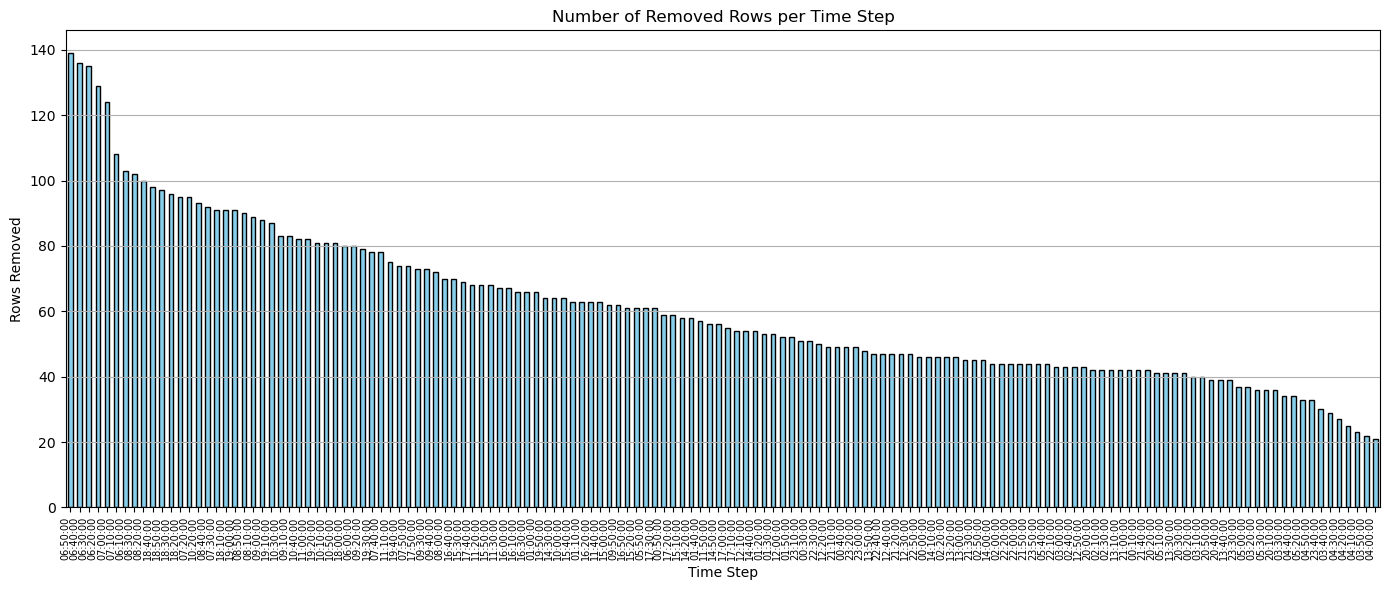

In [108]:
# Basic bar plot of removed rows per time step
plt.figure(figsize=(14, 6))
removed_by_time.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Removed Rows per Time Step')
plt.xlabel('Time Step')
plt.ylabel('Rows Removed')
plt.xticks(rotation=90, ha='right')  # Adjust for readability
plt.xticks(fontsize=7)
plt.tight_layout()
plt.grid(axis='y')

plt.savefig('./Figures_Exports/cleaned_rows_per_timestamp.png')
plt.show()

In [109]:
nan_counts_s2_after = df_step2.isna().sum()
print(nan_counts_s2_after)

Datetime          0
Temp         246081
station           0
month             0
Temp_mean         0
Temp_std          0
TimeOnly          0
dtype: int64


In [110]:
# This difference shows the number of cleaned rows (based on no. of NaNs before and after cleaning)
diff_s2_a = df_step2['Temp'].isna().sum() - CML_10min['Temp'].isna().sum()
diff_s2_b = df_step2['Temp'].isna().sum() - df_step1['Temp'].isna().sum()
print(f"Number of cleaned rows after second step compared to not cleaned 10-min dataset: {diff_s2_a}")
print(f"Number of cleaned rows after second step compared to first step: {diff_s2_b}")
print(f"Number of cleaned rows after first step: {2287}")

Number of cleaned rows after second step compared to not cleaned 10-min dataset: 11076
Number of cleaned rows after second step compared to first step: 8789
Number of cleaned rows after first step: 2287


**Here we check number of removed observations per station**

In [111]:
# Reset index
CML_10min.reset_index(drop=True, inplace=True)
df_step2.reset_index(drop=True, inplace=True)

# Create a mask for valid (non-NaN) original rows
valid_original_mask = CML_10min['Temp'].notna()

# Identify removed rows
removed_rows_mask = valid_original_mask & df_step2['Temp'].isna()

# Count removed rows and valid original rows per station
removed_by_station = CML_10min.loc[removed_rows_mask].groupby('station').size()
valid_rows_by_station = CML_10min.loc[valid_original_mask].groupby('station').size()

# Cleaning stats per station
station_cleaning_stats = pd.DataFrame({'station': valid_rows_by_station.index})
station_cleaning_stats['removed'] = station_cleaning_stats['station'].map(removed_by_station).fillna(0)
station_cleaning_stats['total_valid'] = station_cleaning_stats['station'].map(valid_rows_by_station).fillna(1)
station_cleaning_stats['removed_pct'] = (station_cleaning_stats['removed'] / station_cleaning_stats['total_valid']) * 100

# Load coordinates and merge additional info
coords = pd.read_csv('./Data/CML-ARPA/CML_metadata.csv')
station_cleaning_stats = station_cleaning_stats.merge(
    coords[['station', 'lat', 'long', 'Instrument height', 'Surface', 'alt slm']],
    on='station',
    how='left'
)
station_cleaning_stats.dropna(subset=['lat', 'long'], inplace=True)

# Define color based on removal percentage
def get_color(pct):
    if pct < 0.5:
        return 'lightgreen'
    elif pct < 1.0:
        return 'orange'
    else:
        return 'red'

station_cleaning_stats['color'] = station_cleaning_stats['removed_pct'].apply(get_color)

# Create map
map_center = [station_cleaning_stats['lat'].mean(), station_cleaning_stats['long'].mean()]
m = folium.Map(
    location=map_center,
    zoom_start=10,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='esri'
)

# Add markers with enhanced popup info
for _, row in station_cleaning_stats.iterrows():
    popup_text = (
        f"<b>Station:</b> {row['station']}<br>"
        f"<b>Removed:</b> {int(row['removed'])} rows<br>"
        f"<b>Percentage:</b> {row['removed_pct']:.2f}%<br>"
        f"<b>Altitude:</b> {row['alt slm']} m <br>"
        f"<b>Instrument height:</b> {row['Instrument height']} m <br>"
        f"<b>Surface:</b> {row['Surface']}"
    )
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=6,
        color=row['color'],
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Add legend
legend_html = """
<div style="
     position: fixed;
     bottom: 40px;
     left: 40px;
     width: 130px;
     height: 140px;
     background-color: white;
     border:2px solid grey;
     z-index:9999;
     font-size:18px;
     padding: 10px;
     box-shadow: 2px 2px 5px rgba(0,0,0,0.4);
     ">
<b>Cleaning %</b><br>
<i style="background:lightgreen; width:10px; height:10px; display:inline-block;"></i>
 &lt; 0.5%<br>
<i style="background:orange; width:10px; height:10px; display:inline-block;"></i>
 0.5 – 1%<br>
<i style="background:red; width:10px; height:10px; display:inline-block;"></i>
 > 1%<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save and/or display
m.save("./Figures_Exports/stations_cleaning_map.html")
m  # For display in Jupyter

In [112]:
valid_rows_by_station

station
abbiategrasso    51440
bollate          52555
brignano         52542
caleppio         52546
canegrate        51349
                 ...  
vignate          43472
villasanta       51490
vimodrone        37169
vizzola          39763
zerbolo          39763
Length: 63, dtype: int64

In [113]:
# Export cleaning stats to GPKG to create map

gdf = gpd.GeoDataFrame(
    station_cleaning_stats,
    geometry=gpd.points_from_xy(station_cleaning_stats['long'], station_cleaning_stats['lat']),
    crs='EPSG:4326'  # WGS84
)

gdf.to_file("./Figures_Exports/station_cleaning_stats.gpkg", driver="GPKG", layer='stations')

# **Aggregation of CML and ARPA to one hour intervals**

After the cleaning is done the temperatures are merged into one hour intervals.

## **CML**

In [114]:
df_step2 = df_step2.reset_index()

In [115]:
def average_chunks_CML(df, chunk_size, resample_freq):
    results = []
    for station, group in df.groupby('station'):
        group = group.sort_values('Datetime').reset_index(drop=True)
        n_chunks = len(group) // chunk_size
        if n_chunks == 0:
            continue
        truncated = group.iloc[:n_chunks * chunk_size]
        
        reshaped = truncated['Temp'].values.reshape(-1, chunk_size)

        # Initialize an array to hold the mean temperatures
        mean_temps = []

        for chunk in reshaped:
            # Check if the chunk has any valid values before computing the mean
            if np.count_nonzero(~np.isnan(chunk)) == 0:
                mean_temps.append(np.nan)  # If all values are NaN, append NaN
            else:
                mean_temps.append(np.nanmean(chunk))  # Compute mean, ignoring NaNs

        # Assign the last timestamp in each chunk, floored to the desired interval
        timestamps = truncated['Datetime'].values.reshape(-1, chunk_size)[:, -1]
        timestamps = pd.to_datetime(timestamps).floor(resample_freq)
        timestamps += pd.Timedelta(hours=1)

        result_df = pd.DataFrame({
            'Datetime': timestamps,
            'Temp': mean_temps,
            'station': station
        })
        results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [116]:
# Aggregate to 1-hour intervals directly (6 10-min intervals per hour)
CML_hourly = average_chunks_CML(df_step2, chunk_size=6, resample_freq='H')

In [117]:
CML_hourly['Temp'] = CML_hourly['Temp'].round(2)

In [118]:
CML_hourly

,Datetime,Temp,station
0,2022-01-01 01:00:00,-0.11,abbiategrasso
1,2022-01-01 02:00:00,-0.17,abbiategrasso
2,2022-01-01 03:00:00,-0.37,abbiategrasso
3,2022-01-01 04:00:00,-0.39,abbiategrasso
4,2022-01-01 05:00:00,-0.61,abbiategrasso
...,...,...,...
551875,2022-12-31 20:00:00,NaN,zerbolo
551876,2022-12-31 21:00:00,NaN,zerbolo
551877,2022-12-31 22:00:00,NaN,zerbolo
551878,2022-12-31 23:00:00,NaN,zerbolo


In [119]:
# Load the CML metadata file
CML_lat_lon = pd.read_csv("./Data/CML-ARPA/CML_metadata.csv")

# Merge using 'station' as key
CML_hourly_final = CML_hourly.merge(
    CML_lat_lon[['station','lat', 'long']],
    on='station',
    how='left'
)

# Check result
print(CML_hourly_final[['station', 'lat', 'long']].head())

         station        lat      long
0  abbiategrasso  45.381389  8.911667
1  abbiategrasso  45.381389  8.911667
2  abbiategrasso  45.381389  8.911667
3  abbiategrasso  45.381389  8.911667
4  abbiategrasso  45.381389  8.911667


In [120]:
unique_station_count = CML_hourly_final['station'].nunique()
print(f"Number of unique station IDs: {unique_station_count}")

Number of unique station IDs: 63


In [121]:
#df_combined_hourly
print(CML_hourly_final[CML_hourly_final['station'] == 'sedriano'])

                  Datetime  Temp   station        lat      long
438000 2022-01-01 01:00:00  0.31  sedriano  45.495833  8.966389
438001 2022-01-01 02:00:00  0.36  sedriano  45.495833  8.966389
438002 2022-01-01 03:00:00  0.21  sedriano  45.495833  8.966389
438003 2022-01-01 04:00:00  0.36  sedriano  45.495833  8.966389
438004 2022-01-01 05:00:00  0.76  sedriano  45.495833  8.966389
...                    ...   ...       ...        ...       ...
446755 2022-12-31 20:00:00   NaN  sedriano  45.495833  8.966389
446756 2022-12-31 21:00:00   NaN  sedriano  45.495833  8.966389
446757 2022-12-31 22:00:00   NaN  sedriano  45.495833  8.966389
446758 2022-12-31 23:00:00   NaN  sedriano  45.495833  8.966389
446759 2023-01-01 00:00:00   NaN  sedriano  45.495833  8.966389

[8760 rows x 5 columns]


In [122]:
nan_hourly = CML_hourly_final[CML_hourly_final['Temp'].isna()].groupby('station').size()
print(nan_hourly.to_string())

station
abbiategrasso           181
brignano                  2
canegrate               198
capergnanica            529
carimate                290
casarile               3888
casorateprimo           344
cassano_adda              9
castano                 143
ceriano_laghetto         14
cesate                  198
cirimido                292
cisliano                536
corbetta                186
credera                 182
cremosano                 8
crenna                 2417
filago                  250
gaggiano               2754
geromina                219
gualdrasco                1
inveruno                161
magherno                261
marcallo                268
mariano                 505
mediglia                219
melegnano               402
mi_boscoincitta         293
mi_genova               198
mi_parconord            679
mi_sanleonardo         2679
monza                   126
mortara_vvf             368
nizzolina               188
nosate                  304
novamilanese

In [123]:
# Count total number of NaN values
total_nans = CML_hourly_final['Temp'].isna().sum()
print(f"Total NaNs in Temp column: {total_nans}")

Total NaNs in Temp column: 39143


In total, there are 39143 rows with missing values (7.1% of the full dataset of 551880 rows) - but that also includes originally missing values, not only the ones removed by the cleaning process.

In [124]:
# Export to csv and parquet
# This is without altitude correction which is done below
CML_hourly_final.to_csv(CML_source + 'CML_2022_hourly_cleaned.csv', index=False)
CML_hourly_final.to_parquet(CML_source + 'CML_2022_hourly_cleaned.parquet', index=False)

## **ARPA**

In [125]:
arpa_stations = pd.read_parquet(ARPA_source + 'ARPA_2022_cleaned.parquet')

In [126]:
arpa_stations

,Id,Datetime,Temp,zscore
0,2327,2022-01-01 00:00:00,1.8,-0.306364
1,4058,2022-01-01 00:00:00,-0.4,-0.813590
2,9027,2022-01-01 00:00:00,2.0,-0.260253
3,9026,2022-01-01 00:00:00,4.7,0.362252
4,8212,2022-01-01 00:00:00,1.4,-0.398587
...,...,...,...,...
1787035,8162,2022-12-31 23:50:00,8.0,0.912337
1787036,2187,2022-12-31 23:50:00,8.3,1.010660
1787037,5920,2022-12-31 23:50:00,8.0,0.912337
1787038,7029,2022-12-31 23:50:00,7.3,0.682919


In [127]:
# Ensure datetime is a column and not index
if arpa_stations.index.name == 'Datetime':
    arpa_stations = arpa_stations.reset_index()

In [128]:
def average_chunks_arpa(df, chunk_size=6, resample_freq='H'):
    results = []
    for station, group in df.groupby('Id'):
        group = group.sort_values('Datetime').reset_index(drop=True)
        n_chunks = len(group) // chunk_size
        if n_chunks == 0:
            continue
        truncated = group.iloc[:n_chunks * chunk_size]

        reshaped = truncated['Temp'].values.reshape(-1, chunk_size)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_temps = np.nanmean(reshaped, axis=1)

        timestamps = truncated['Datetime'].values.reshape(-1, chunk_size)[:, 1]
        timestamps = pd.to_datetime(timestamps).floor(resample_freq)
        timestamps += pd.Timedelta(hours=1) 

        result_df = pd.DataFrame({
            'Datetime': timestamps,
            'Temp': mean_temps,
            'Id': station
        })
        results.append(result_df)

    return pd.concat(results, ignore_index=True)

# Aggregate ARPA data
arpa_hourly = average_chunks_arpa(arpa_stations)

# Optional: see number of NaNs
print("Total NaNs in hourly ARPA:", arpa_hourly['Temp'].isna().sum())

Total NaNs in hourly ARPA: 1110


Missing rows of ARPA (1110) are 0.5% of the full dataset which is 297840 rows.

In [129]:
arpa_hourly['Temp'] = arpa_hourly['Temp'].round(2)

In [130]:
arpa_hourly

,Datetime,Temp,Id
0,2022-01-01 01:00:00,-0.55,2001
1,2022-01-01 02:00:00,-0.42,2001
2,2022-01-01 03:00:00,0.68,2001
3,2022-01-01 04:00:00,1.38,2001
4,2022-01-01 05:00:00,0.75,2001
...,...,...,...
297835,2022-12-31 20:00:00,8.57,19426
297836,2022-12-31 21:00:00,8.35,19426
297837,2022-12-31 22:00:00,8.17,19426
297838,2022-12-31 23:00:00,8.05,19426


Let's add lat/long and station name info to ARPA

In [131]:
# Load the ARPA metadata file
arpa_lat_lon = pd.read_csv("./Data/CML-ARPA/ARPA_metadata.csv")

# Merge using 'Id Sensore' as key
arpa_hourly_final = arpa_hourly.merge(
    arpa_lat_lon[['Id', 'station', 'lat', 'long']],
    on='Id',
    how='left'
)

# Check result
print(arpa_hourly_final[['Id', 'station', 'lat', 'long']].head())

     Id          station       lat      long
0  2001  Milano Lambrate  45.49678  9.257515
1  2001  Milano Lambrate  45.49678  9.257515
2  2001  Milano Lambrate  45.49678  9.257515
3  2001  Milano Lambrate  45.49678  9.257515
4  2001  Milano Lambrate  45.49678  9.257515


In [132]:
arpa_hourly_final

,Datetime,Temp,Id,station,lat,long
0,2022-01-01 01:00:00,-0.55,2001,Milano Lambrate,45.496780,9.257515
1,2022-01-01 02:00:00,-0.42,2001,Milano Lambrate,45.496780,9.257515
2,2022-01-01 03:00:00,0.68,2001,Milano Lambrate,45.496780,9.257515
3,2022-01-01 04:00:00,1.38,2001,Milano Lambrate,45.496780,9.257515
4,2022-01-01 05:00:00,0.75,2001,Milano Lambrate,45.496780,9.257515
...,...,...,...,...,...,...
297835,2022-12-31 20:00:00,8.57,19426,Mariano Comense campo sportivo,45.684883,9.177769
297836,2022-12-31 21:00:00,8.35,19426,Mariano Comense campo sportivo,45.684883,9.177769
297837,2022-12-31 22:00:00,8.17,19426,Mariano Comense campo sportivo,45.684883,9.177769
297838,2022-12-31 23:00:00,8.05,19426,Mariano Comense campo sportivo,45.684883,9.177769


In [133]:
# Export to csv and parquet
arpa_hourly_final.to_csv(ARPA_source + 'ARPA_2022_hourly_cleaned.csv', index=False)
arpa_hourly_final.to_parquet(ARPA_source + 'ARPA_2022_hourly_cleaned.parquet', index=False)

----------
**Quick recap CML:**
- From the first step of cleaning unrealistic values (+/- 2 °C), a total of 2287 values were removed.
- From the second step of cleaning unrealistic values (+/- 3 STDEV), an additional 8789 values were removed.

This is a total of **11076** values removed from the 10-min df (0.33%). 
Lastly, there are **39143** rows with missing values for the final hourly df (7.1% of the full dataset, 551880 rows). This also includes originally missing values.

**Quick recap ARPA:**
- Some values (such as -999) were removed (**7560**).
- Z-score outlier removal resulted in **1026** values removed at a 10-min interval.
- Totally, **1110** missing values are present in the final hourly df (0.4% of the full dataset, 297840 rows).

----------

## **Adding metadata to the exports**

In [134]:
# Create ARPA and CML Virtual Station of one hour measurements
cml_VS_1h = CML_hourly_final.groupby('Datetime')['Temp'].agg(Temp_mean='mean').reset_index()
cml_VS_1h['station'] = 'CML_Virtual'

arpa_VS_1h = arpa_hourly_final.groupby('Datetime')['Temp'].agg(Temp_mean='mean').reset_index()
arpa_VS_1h['station'] = 'ARPA_Virtual'

arpa_VS_1h.to_parquet(ARPA_source + 'ARPA_VS_1h.parquet', index=False)
cml_VS_1h.to_parquet(CML_source + 'CML_VS_1h.parquet', index=False)

Add urban/natural and altitude information to ARPA/CML Stations and export to metadata parquet

In [135]:
# Load the urban/rural classification file
lcz_df = pd.read_csv('./Data/CML-ARPA/ARPA_CML_metadata.csv', delimiter=',')

In [136]:
lcz_df

,fid,Id,station,lat,long,dominant_class,dominant_pct,network,train/test,urban/natural,building_height,sensor_height,altitude,altitude1,Altitude-group
0,23,2122,Sant'Angelo Lodigiano,45.260667,9.379660,104,90.91,ARPA,test,natural,0,1.5,60,61.5,50-100
1,53,credera,credera,45.305556,9.639167,6,60.47,CML,train,urban,0,2.5,64,66.5,50-100
2,4,2327,Cavenago d'Adda,45.269274,9.562660,106,78.26,ARPA,test,natural,0,1.5,67,68.5,50-100
3,51,sanangelo_lodigiano,sanangelo_lodigiano,45.233889,9.397778,6,69.05,CML,train,urban,0,3.0,68,71.0,50-100
4,61,magherno,magherno,45.224167,9.332222,6,93.18,CML,train,urban,0,2.5,73,75.5,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2,crenna,crenna,45.681667,8.798889,6,65.22,CML,train,urban,0,2.0,258,260.0,250-400
93,34,9027,Cavaria con Premezzo v. Cantalupa,45.689494,8.807690,6,79.07,ARPA,train,urban,0,1.5,274,275.5,250-400
94,8,cirimido,cirimido,45.685278,9.011111,106,47.73,CML,train,natural,0,10.0,270,280.0,250-400
95,32,9026,Lurago Marinone,45.704966,8.988338,6,79.55,ARPA,train,urban,0,1.7,296,297.7,250-400


In [137]:
# Add metadata and export

arpa_hourly_final['Id'] = arpa_hourly_final['Id'].astype(str)
CML_hourly_final['station'] = CML_hourly_final['station'].astype(str)
lcz_df['Id'] = lcz_df['Id'].astype(str)

# Filter CSV by network and select only keys + urban/natural
# In lcz_df there is altitude and altitude1 column. Altitude is only elevation, while altitude1 is elevation + building and sensor height
lcz_arpa = lcz_df[lcz_df['network'] == 'ARPA'][['Id', 'urban/natural', 'altitude1', 'Altitude-group']]
lcz_cml = lcz_df[lcz_df['network'] == 'CML'][['Id', 'urban/natural', 'altitude1', 'Altitude-group']]

# Merge for ARPA on 'Id'
arpa_hourly_final = arpa_hourly_final.merge(lcz_arpa, on='Id', how='left')

# Merge for CML on 'station' (left) and 'Id' (right)
CML_hourly_final = CML_hourly_final.merge(lcz_cml, left_on='station', right_on='Id', how='left')

# Export
arpa_hourly_final.to_parquet(ARPA_source + 'ARPA_2022_hourly_cleaned_metadata.parquet', index=False)
CML_hourly_final.to_parquet(CML_source + 'CML_2022_hourly_cleaned_metadata.parquet', index=False)

# **Elevation correction**

Air temperature observations are affected by the elevation; we want to correct for that effect and put the stations at the same elevation. In this case, that is the mean elevation of the city, which is 141 m. A common lapse rate of 0.0065 °C/m is used to correct observations.

In [138]:
arpa_1h_metadata = pd.read_parquet(ARPA_source + 'ARPA_2022_hourly_cleaned_metadata.parquet')
cml_1h_metadata = pd.read_parquet(CML_source + 'CML_2022_hourly_cleaned_metadata.parquet')

# Combine to compute reference elevation
combined_alt = pd.concat([arpa_1h_metadata[['altitude1']], cml_1h_metadata[['altitude1']]])
mean_elevation = 141
print(f"Mean reference elevation: {mean_elevation:.2f} meters")

# Define lapse rate (°C/m)
lapse_rate = 0.0065

# Apply correction
arpa_1h_metadata['Temp_corrected'] = (arpa_1h_metadata['Temp'] + lapse_rate * (mean_elevation - arpa_1h_metadata['altitude1'])).round(2)
cml_1h_metadata['Temp_corrected'] = (cml_1h_metadata['Temp'] + lapse_rate * (mean_elevation - cml_1h_metadata['altitude1'])).round(2)

# Export
arpa_1h_metadata.to_parquet(ARPA_source + 'ARPA_2022_hourly_altcorr.parquet', index=False)
cml_1h_metadata.to_parquet(CML_source + 'CML_2022_hourly_altcorr.parquet', index=False)

Mean reference elevation: 141.00 meters


# **Plotting hourly data**

In [139]:
# This is the original non-corrected elevation dataset without metadata
arpa_1h = pd.read_parquet(ARPA_source + 'ARPA_2022_hourly_cleaned.parquet')
cml_1h = pd.read_parquet(CML_source + 'CML_2022_hourly_cleaned.parquet')

In [140]:
# This is the original non-corrected elevation dataset with metadata
arpa_1h_metadata = pd.read_parquet(ARPA_source + 'ARPA_2022_hourly_cleaned_metadata.parquet')
cml_1h_metadata = pd.read_parquet(CML_source + 'CML_2022_hourly_cleaned_metadata.parquet')

# This is the only elevation-corrected dataset
arpa_1h_alt_corr = pd.read_parquet(ARPA_source + 'ARPA_2022_hourly_altcorr.parquet')
cml_1h_alt_corr = pd.read_parquet(CML_source + 'CML_2022_hourly_altcorr.parquet')

In [141]:
# This is the original non-corrected elevation dataset for VS
arpa_VS_1h = pd.read_parquet(ARPA_source + 'ARPA_VS_1h.parquet')
cml_VS_1h = pd.read_parquet(CML_source + 'CML_VS_1h.parquet')

In [142]:
cml_1h

,Datetime,Temp,station,lat,long
0,2022-01-01 01:00:00,-0.11,abbiategrasso,45.381389,8.911667
1,2022-01-01 02:00:00,-0.17,abbiategrasso,45.381389,8.911667
2,2022-01-01 03:00:00,-0.37,abbiategrasso,45.381389,8.911667
3,2022-01-01 04:00:00,-0.39,abbiategrasso,45.381389,8.911667
4,2022-01-01 05:00:00,-0.61,abbiategrasso,45.381389,8.911667
...,...,...,...,...,...
551875,2022-12-31 20:00:00,NaN,zerbolo,45.227222,8.985000
551876,2022-12-31 21:00:00,NaN,zerbolo,45.227222,8.985000
551877,2022-12-31 22:00:00,NaN,zerbolo,45.227222,8.985000
551878,2022-12-31 23:00:00,NaN,zerbolo,45.227222,8.985000


In [143]:
# Ensure datetime columns are datetime type
arpa_1h['Datetime'] = pd.to_datetime(arpa_1h['Datetime'])
cml_1h['Datetime'] = pd.to_datetime(cml_1h['Datetime'])

# Create dropdowns for station selection
station_dropdown_cml = widgets.Dropdown(
    options=sorted(cml_1h['station'].unique()),
    description='CML Station:',
    layout=widgets.Layout(width='50%')
)

station_dropdown_arpa = widgets.Dropdown(
    options=sorted(arpa_1h['station'].unique()),
    description='ARPA Station:',
    layout=widgets.Layout(width='50%')
)

month_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 13)],
    description='Month:',
    layout=widgets.Layout(width='50%')
)

day_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 32)],
    description='Day:',
    layout=widgets.Layout(width='50%')
)

In [144]:
# Plotting function. Allows selection of each CML and ARPA station.

def plot_stations_cml_vs_arpa(cml_station, arpa_station, month, day):
    df_cml = cml_1h[cml_1h['station'] == cml_station].copy()
    df_arpa = arpa_1h[arpa_1h['station'] == arpa_station].copy()

    df_cml = df_cml[df_cml['Datetime'].dt.year == 2022]
    df_arpa = df_arpa[df_arpa['Datetime'].dt.year == 2022]

    if month != 'all':
        df_cml = df_cml[df_cml['Datetime'].dt.month == month]
        df_arpa = df_arpa[df_arpa['Datetime'].dt.month == month]

    if day != 'all':
        df_cml = df_cml[df_cml['Datetime'].dt.day == day]
        df_arpa = df_arpa[df_arpa['Datetime'].dt.day == day]

    df_cml = df_cml.dropna(subset=['Temp', 'Datetime'])
    df_arpa = df_arpa.dropna(subset=['Temp', 'Datetime'])

    if df_cml.empty and df_arpa.empty:
        print("No data available for this selection.")
        return

    plt.figure(figsize=(15, 4))

    if not df_cml.empty:
        plt.plot(df_cml['Datetime'], df_cml['Temp'], label=f'CML {cml_station} Temp',
                 color='tab:blue', marker='.', linestyle='-', markersize=1.5)

    if not df_arpa.empty:
        plt.plot(df_arpa['Datetime'], df_arpa['Temp'], label=f'ARPA {arpa_station} Temp',
                 color='tab:orange', marker='.', linestyle='-', markersize=1.5)

    title = f"Temperature: CML {cml_station} vs ARPA {arpa_station} - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"

    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run interactive widget
widgets.interact(
    plot_stations_cml_vs_arpa,
    cml_station=station_dropdown_cml,
    arpa_station=station_dropdown_arpa,
    month=month_dropdown,
    day=day_dropdown
)

interactive(children=(Dropdown(description='CML Station:', layout=Layout(width='50%'), options=('abbiategrasso…

<function __main__.plot_stations_cml_vs_arpa(cml_station, arpa_station, month, day)>

In [145]:
# Plotting function. Shows CML and ARPA VS time series.

def plot_virtual_comparison(month, day):
    # Use precomputed virtual station DataFrames
    arpa_filtered = arpa_VS_1h.copy()
    cml_virtual = cml_VS_1h.copy()

    # Filter by year 2022
    arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.year == 2022]
    cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.year == 2022]

    # Filter by month
    if month != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.month == month]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.month == month]

    # Filter by day
    if day != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.day == day]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.day == day]

    # Drop NaNs
    cml_virtual = cml_virtual.dropna(subset=['Temp_mean', 'Datetime'])
    arpa_filtered = arpa_filtered.dropna(subset=['Temp_mean', 'Datetime'])

    if cml_virtual.empty and arpa_filtered.empty:
        print("No data available for this selection.")
        return

    # Plotting
    plt.figure(figsize=(15, 4))

    plt.plot(cml_virtual['Datetime'], cml_virtual['Temp_mean'], color='tab:blue',
             marker='.', linestyle='-', markersize=1.5, label='CML Virtual Temp')

    plt.plot(arpa_filtered['Datetime'], arpa_filtered['Temp_mean'], color='tab:orange',
             marker='.', linestyle='-', markersize=1.5, label='ARPA Virtual Temp')

    # Title
    title = "CML Virtual vs ARPA Virtual - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    # X-axis formatting
    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

widgets.interact(plot_virtual_comparison, month=month_dropdown, day=day_dropdown)

interactive(children=(Dropdown(description='Month:', layout=Layout(width='50%'), options=(('All', 'all'), ('1'…

<function __main__.plot_virtual_comparison(month, day)>

**Plot average annual diurnal cycle of air temperatures for both CML and ARPA**

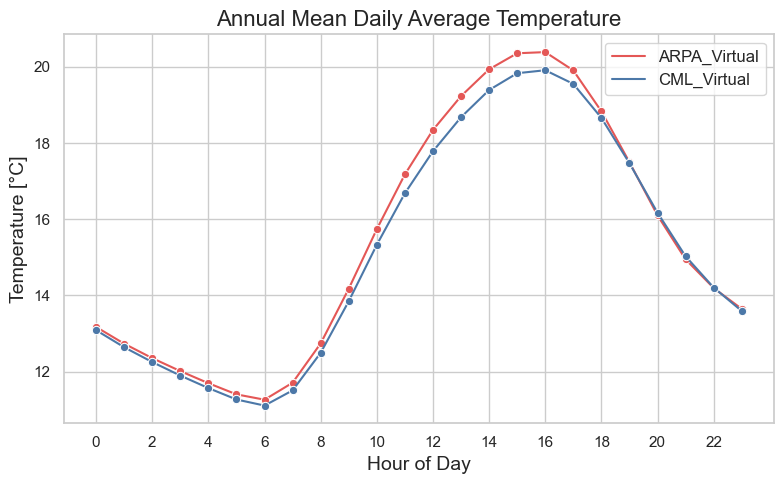

In [146]:
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})

# Combine both into one tidy DataFrame
combined = pd.concat([arpa_VS_1h, cml_VS_1h], ignore_index=True)
combined['Datetime'] = pd.to_datetime(combined['Datetime'])
combined['hour'] = combined['Datetime'].dt.hour

# Compute diurnal average per source
diurnal = combined.groupby(['station', 'hour'])['Temp_mean'].mean().reset_index()

# Use flat, sharp custom colors
palette = ['#E45756', '#4C78A8']  # red and blue

plt.figure(figsize=(8, 5))
sns.lineplot(data=diurnal, x='hour', y='Temp_mean', hue='station', marker='o', palette=palette)

plt.title('Annual Mean Daily Average Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature [°C]')
plt.xticks(range(0, 24, 2))
plt.legend(title='')
plt.tight_layout()

plt.savefig("./Figures_Exports/diurnal_temp_clean.png", dpi=300)
plt.show()

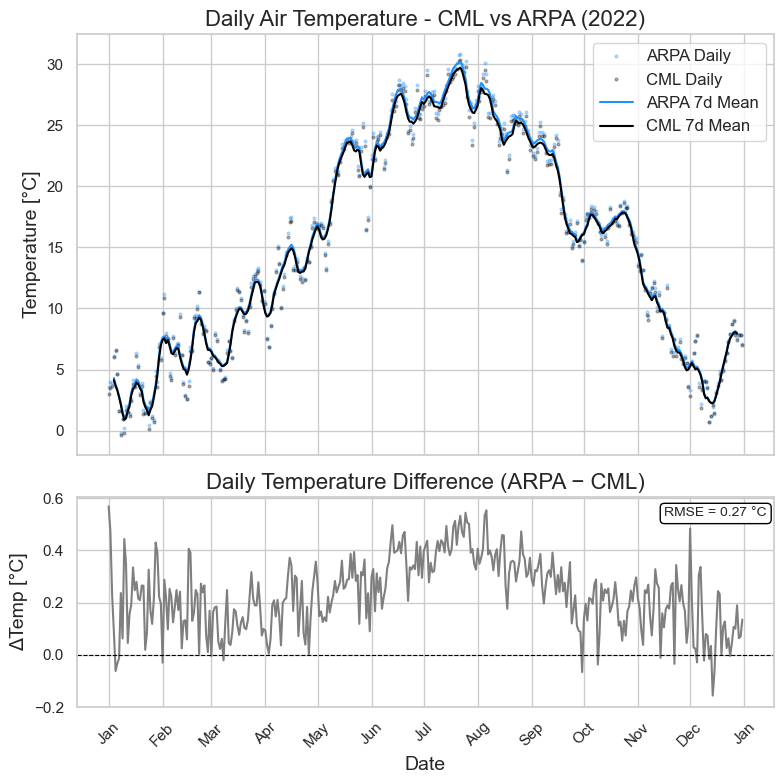

In [147]:
arpa_df = pd.read_parquet(ARPA_source + 'ARPA_VS_1h.parquet')
cml_df = pd.read_parquet(CML_source + 'CML_VS_1h.parquet')

# Filter for 2022
arpa_df = arpa_df[arpa_df['Datetime'].dt.year == 2022]
cml_df = cml_df[cml_df['Datetime'].dt.year == 2022]

# Drop NaNs
arpa_df = arpa_df.dropna(subset=['Temp_mean', 'Datetime'])
cml_df = cml_df.dropna(subset=['Temp_mean', 'Datetime'])

# Compute daily means
arpa_daily = arpa_df.resample('D', on='Datetime').mean(numeric_only=True).reset_index()
cml_daily = cml_df.resample('D', on='Datetime').mean(numeric_only=True).reset_index()

# Rolling mean (7-day)
arpa_daily['Temp_mean_roll'] = arpa_daily['Temp_mean'].rolling(window=7, center=True).mean()
cml_daily['Temp_mean_roll'] = cml_daily['Temp_mean'].rolling(window=7, center=True).mean()

# Merge for difference
merged = pd.merge(arpa_daily[['Datetime', 'Temp_mean']], 
                  cml_daily[['Datetime', 'Temp_mean']], 
                  on='Datetime', suffixes=('_arpa', '_cml'))
merged['diff'] = merged['Temp_mean_arpa'] - merged['Temp_mean_cml']

# Compute RMSE
rmse = np.sqrt(np.mean((merged['Temp_mean_arpa'] - merged['Temp_mean_cml'])**2))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top panel: ARPA & CML daily temps
ax1.plot(arpa_daily['Datetime'], arpa_daily['Temp_mean'], 'o', color='#1e90ff', alpha=0.3, markersize=2, label='ARPA Daily')
ax1.plot(cml_daily['Datetime'], cml_daily['Temp_mean'], 'o', color='black', alpha=0.3, markersize=2, label='CML Daily')

ax1.plot(arpa_daily['Datetime'], arpa_daily['Temp_mean_roll'], '-', color='#1e90ff', label='ARPA 7d Mean')
ax1.plot(cml_daily['Datetime'], cml_daily['Temp_mean_roll'], '-', color='black', label='CML 7d Mean')

ax1.set_ylabel('Temperature [°C]')
ax1.set_title('Daily Air Temperature - CML vs ARPA (2022)')
ax1.legend()
ax1.grid(True)

# Bottom panel: Difference
ax2.plot(merged['Datetime'], merged['diff'], '-', color='tab:gray')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_ylabel('ΔTemp [°C]')
ax2.set_ylim(bottom=-0.2)
ax2.set_xlabel('Date')
ax2.set_title('Daily Temperature Difference (ARPA − CML)')
ax2.grid(True)

# Annotate RMSE
ax2.text(0.99, 0.95, f'RMSE = {rmse:.2f} °C', transform=ax2.transAxes,
         ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# X-axis formatting
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("./Figures_Exports/Daily_annual.png", dpi=600)
plt.show()